<a href="https://colab.research.google.com/github/Orri050/Lokaverkefni/blob/main/Lokaverkefni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forritið

## Grunnur

In [421]:
pip install yfinance

In [422]:
import tensorflow as tf
import math
from pandas.tseries.offsets import DateOffset
from datetime import timedelta, date
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Val á hlutabréfi

In [676]:
choice = input('Write a stock symbol:')
choice = choice.upper()

Write a stock symbol:AAL


## Hlutabréf gögn

In [677]:
#data = yf.download(tickers=choice, start="2019-03-04", end="2022-04-18", interval='1d')
data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)

[*********************100%***********************]  1 of 1 completed


In [678]:
data_Open=data[['Open']] 
data_dates=data.index.to_frame().reset_index(drop=True)
data_dates=data_dates.apply(pd.to_datetime)

### yf.ticker 

In [679]:
yf.pdr_override()
stock = yf.Ticker(choice)

In [680]:
#stockh = stock.history(period='max',start="2019-03-04",end="2022-04-18", interval='1d')
stockh = stock.history(period='max', interval='1d')
stockh

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-09-27,19.844703,20.174663,18.006359,18.194906,961200,0.0,0
2005-09-28,18.194908,19.354481,18.100635,19.326199,5747900,0.0,0
2005-09-29,19.231922,19.401616,18.949101,19.052801,1078200,0.0,0
2005-09-30,19.099939,19.844704,19.024520,19.806995,3123300,0.0,0
2005-10-03,19.703300,20.504631,19.703300,20.268946,1057900,0.0,0
...,...,...,...,...,...,...,...
2022-04-12,17.129999,17.160000,16.690001,17.129999,31461600,0.0,0
2022-04-13,17.879999,18.990000,17.860001,18.950001,90231900,0.0,0
2022-04-14,18.990000,19.490000,18.879999,19.000000,43139700,0.0,0


In [681]:
stockh_dates=stockh.index.to_frame().reset_index(drop=True)
stockh_dates=stockh_dates.apply(pd.to_datetime)

In [682]:
add_dates = [data.index[-1] + DateOffset(days=x) for x in range(0,32) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
#future_dates

## Open close

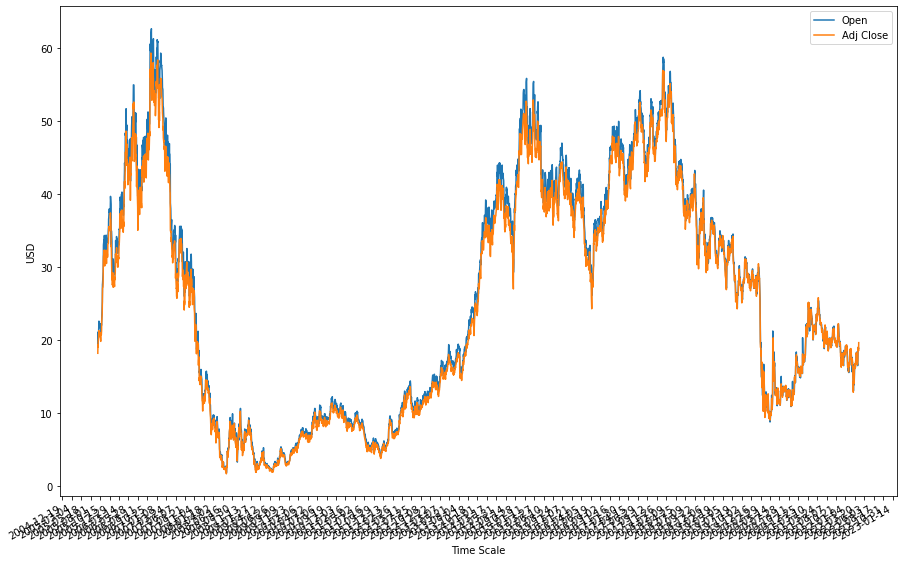

In [683]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['Open'], label='Open')
plt.plot(x_dates, data['Adj Close'], label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## High low

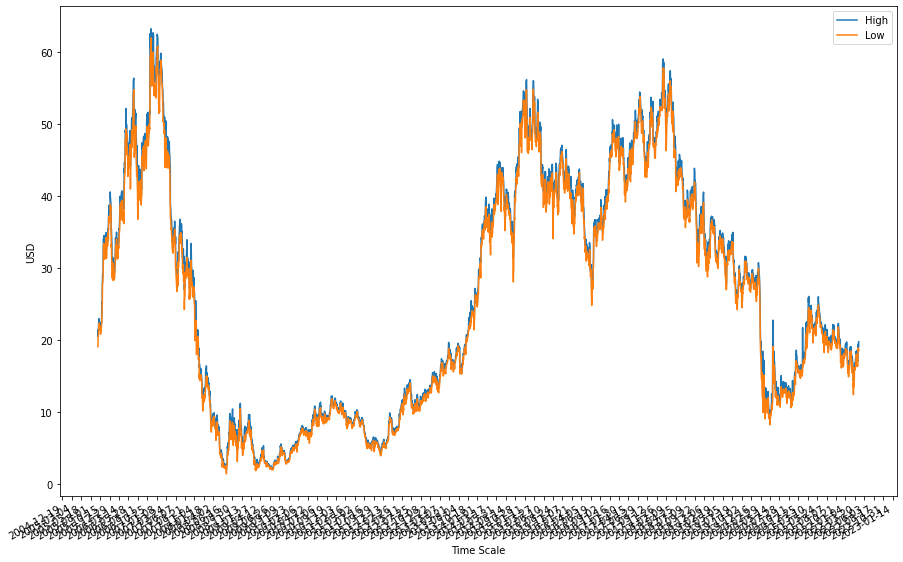

In [684]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['High'], label='High')
plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Fyrsta módel

### Gagnaundirbúningur

In [685]:
target_y = data['Adj Close']
X_feat= data.iloc[:,0:5]
y_feat=data.iloc[:,4]

In [686]:
y_feat

Date
2005-09-27    18.19
2005-09-28    19.33
2005-09-29    19.05
2005-09-30    19.81
2005-10-03    20.27
              ...  
2022-04-12    17.13
2022-04-13    18.95
2022-04-14    19.00
2022-04-18    18.54
2022-04-19    19.65
Name: Adj Close, Length: 4169, dtype: float64

In [687]:
X_feat

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-09-27,21.05,21.40,19.10,19.30,18.19
2005-09-28,19.30,20.53,19.20,20.50,19.33
2005-09-29,20.40,20.58,20.10,20.21,19.05
2005-09-30,20.26,21.05,20.18,21.01,19.81
2005-10-03,20.90,21.75,20.90,21.50,20.27
...,...,...,...,...,...
2022-04-12,17.13,17.16,16.69,17.13,17.13
2022-04-13,17.88,18.99,17.86,18.95,18.95
2022-04-14,18.99,19.49,18.88,19.00,19.00


In [688]:
y_ft=np.array(y_feat)
y_ft=y_ft.reshape(-1,1)

In [689]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)

In [690]:
y_ft=sc.fit_transform(y_ft)

In [691]:
def gagnaskipting(data, n_steps1):
  X, y=[], []
  for i in range(len(data)-n_steps1+1):
    X.append(data[i:i+n_steps1,:-1])
    y.append(data[i+n_steps1-1,-1])

  return np.array(X), np.array(y)


In [692]:
X11, y11= gagnaskipting(X_ft.values, n_steps1=1)

skiptistudull=0.8
skipting= int(np.ceil(len(X11)*skiptistudull))
date_index=X_ft.index

Xtr1, Xtst1= X11[:skipting], X11[skipting:]
ytr1, ytst1= y11[:skipting], y11[skipting:]
Xtrd1, Xtstd1= date_index[:skipting], date_index[skipting:]

print(X11.shape, Xtr1.shape, Xtst1.shape, ytst1.shape)

(4169, 1, 4) (3336, 1, 4) (833, 1, 4) (833,)


### Modelið

In [693]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr1.shape[1],Xtr1.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_66 (LSTM)              (None, 32)                8320      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [694]:
history1=model1.fit(Xtr1,ytr1,epochs=100,validation_data=(Xtst1, ytst1),batch_size=4,verbose=2,shuffle=False)

Epoch 1/100
834/834 - 6s - loss: 0.0501 - val_loss: 9.9308e-04 - 6s/epoch - 7ms/step
Epoch 2/100
834/834 - 3s - loss: 9.7661e-04 - val_loss: 0.0012 - 3s/epoch - 3ms/step
Epoch 3/100
834/834 - 3s - loss: 7.4794e-04 - val_loss: 0.0025 - 3s/epoch - 3ms/step
Epoch 4/100
834/834 - 2s - loss: 6.4979e-04 - val_loss: 0.0042 - 2s/epoch - 3ms/step
Epoch 5/100
834/834 - 3s - loss: 6.7562e-04 - val_loss: 0.0045 - 3s/epoch - 3ms/step
Epoch 6/100
834/834 - 3s - loss: 6.4068e-04 - val_loss: 0.0032 - 3s/epoch - 3ms/step
Epoch 7/100
834/834 - 2s - loss: 5.4599e-04 - val_loss: 0.0028 - 2s/epoch - 3ms/step
Epoch 8/100
834/834 - 3s - loss: 4.6131e-04 - val_loss: 0.0026 - 3s/epoch - 3ms/step
Epoch 9/100
834/834 - 3s - loss: 3.7391e-04 - val_loss: 0.0015 - 3s/epoch - 3ms/step
Epoch 10/100
834/834 - 3s - loss: 3.2799e-04 - val_loss: 0.0017 - 3s/epoch - 3ms/step
Epoch 11/100
834/834 - 3s - loss: 3.6699e-04 - val_loss: 0.0022 - 3s/epoch - 3ms/step
Epoch 12/100
834/834 - 3s - loss: 5.0001e-04 - val_loss: 0.0021

In [695]:
ypr=model1.predict(Xtst1)


### Lærdómskúrva

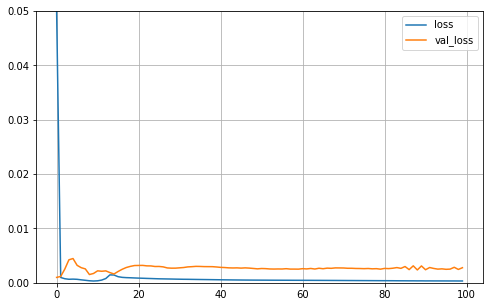

In [696]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.05)
plt.show()

### Samanburður á raunverulegu close og mati LSTM

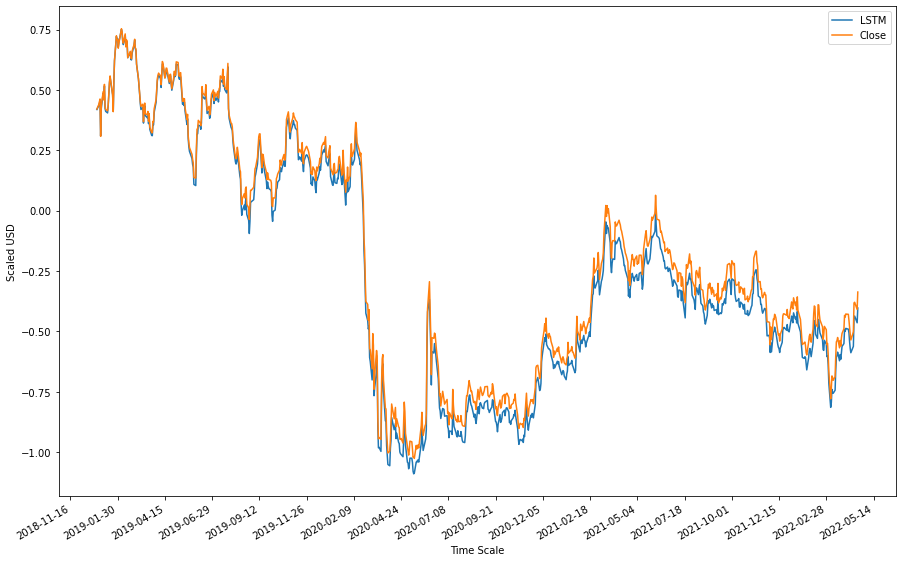

In [697]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
y=y_ft[k:]
plt.plot(x_dates, ypr, label='LSTM')
plt.plot(x_dates, y, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [698]:
rmse=mean_squared_error(ytst1,ypr,squared=False)
mape=mean_absolute_percentage_error(ytst1,ypr)
print("RSME:",rmse)
print("MAPE:",mape)

RSME: 0.05269120674141435
MAPE: 0.2502545795209826


In [699]:
Villa1 = (rmse+mape)/2

## Annað módel

### Þjálfun á modeli

In [700]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr1.shape[1],Xtr1.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model2.compile(loss="mean_squared_error", optimizer="adam")
model2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 1, 50)             11000     
                                                                 
 lstm_68 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_69 (LSTM)              (None, 50)                20200     
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [701]:
history2 = model2.fit(Xtr1, ytr1, epochs=100, batch_size=50, validation_data=(Xtst1, ytst1), verbose=2, shuffle=False)

Epoch 1/100
67/67 - 8s - loss: 0.8544 - val_loss: 0.0082 - 8s/epoch - 118ms/step
Epoch 2/100
67/67 - 0s - loss: 0.0283 - val_loss: 0.0043 - 434ms/epoch - 6ms/step
Epoch 3/100
67/67 - 0s - loss: 0.0313 - val_loss: 0.0056 - 491ms/epoch - 7ms/step
Epoch 4/100
67/67 - 0s - loss: 0.0284 - val_loss: 0.0065 - 451ms/epoch - 7ms/step
Epoch 5/100
67/67 - 0s - loss: 0.0263 - val_loss: 0.0064 - 469ms/epoch - 7ms/step
Epoch 6/100
67/67 - 0s - loss: 0.0249 - val_loss: 0.0057 - 434ms/epoch - 6ms/step
Epoch 7/100
67/67 - 0s - loss: 0.0239 - val_loss: 0.0051 - 469ms/epoch - 7ms/step
Epoch 8/100
67/67 - 0s - loss: 0.0232 - val_loss: 0.0046 - 471ms/epoch - 7ms/step
Epoch 9/100
67/67 - 0s - loss: 0.0225 - val_loss: 0.0043 - 418ms/epoch - 6ms/step
Epoch 10/100
67/67 - 0s - loss: 0.0218 - val_loss: 0.0040 - 435ms/epoch - 6ms/step
Epoch 11/100
67/67 - 0s - loss: 0.0211 - val_loss: 0.0038 - 455ms/epoch - 7ms/step
Epoch 12/100
67/67 - 0s - loss: 0.0204 - val_loss: 0.0037 - 464ms/epoch - 7ms/step
Epoch 13/100
6

In [702]:
ypr2=model2.predict(Xtst1)

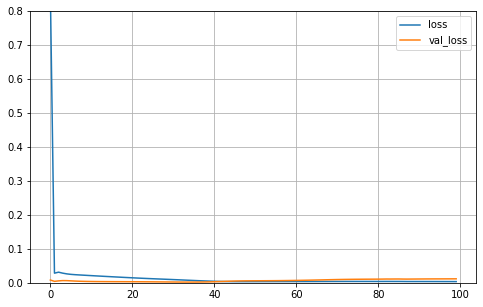

In [703]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

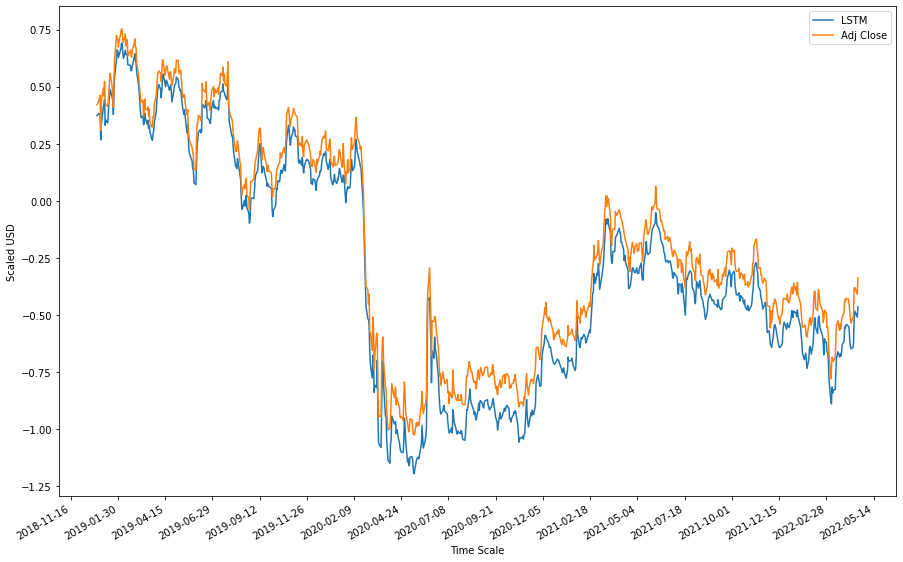

In [704]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
y=y_ft[k:]
plt.plot(x_dates, ypr2, label='LSTM')
plt.plot(x_dates, y, label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [705]:
rmse2=mean_squared_error(ytst1,ypr2,squared=False)
mape2=mean_absolute_percentage_error(ytst1,ypr2)
print("RSME:",rmse2)
print("MAPE:",mape2)

RSME: 0.10814077922854573
MAPE: 0.41282602200608404


In [706]:
Villa2=(rmse2+mape2)/2

## Þriðja módel

### Þjálfun

In [707]:
n_steps1=10
X12, y12= gagnaskipting(X_ft.values, n_steps1=n_steps1)

skiptistudull=0.8
skipting= int(np.ceil(len(X12)*skiptistudull))
date_index=X_ft.index

Xtr2, Xtst2= X12[:skipting], X12[skipting:]
ytr2, ytst2= y12[:skipting], y12[skipting:]
Xtrd2, Xtstd2= date_index[:skipting], date_index[skipting:-n_steps1+1]

print(X12.shape, Xtr2.shape, Xtst2.shape,Xtstd2.shape, ytst2.shape)

(4160, 10, 4) (3328, 10, 4) (832, 10, 4) (832,) (832,)


In [708]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
model3.compile(loss="mean_squared_error", optimizer="adam")

In [709]:
history3 = model3.fit(Xtr2, ytr2, epochs=100, batch_size=50, validation_data=(Xtst2, ytst2), verbose=2, shuffle=False)

Epoch 1/100
67/67 - 6s - loss: 0.2629 - val_loss: 0.0279 - 6s/epoch - 91ms/step
Epoch 2/100
67/67 - 1s - loss: 0.1057 - val_loss: 0.0189 - 988ms/epoch - 15ms/step
Epoch 3/100
67/67 - 1s - loss: 0.0848 - val_loss: 0.0098 - 988ms/epoch - 15ms/step
Epoch 4/100
67/67 - 1s - loss: 0.0833 - val_loss: 0.0094 - 1s/epoch - 15ms/step
Epoch 5/100
67/67 - 1s - loss: 0.0511 - val_loss: 0.0085 - 994ms/epoch - 15ms/step
Epoch 6/100
67/67 - 1s - loss: 0.0554 - val_loss: 0.0101 - 989ms/epoch - 15ms/step
Epoch 7/100
67/67 - 1s - loss: 0.0497 - val_loss: 0.0120 - 989ms/epoch - 15ms/step
Epoch 8/100
67/67 - 1s - loss: 0.0439 - val_loss: 0.0137 - 1s/epoch - 15ms/step
Epoch 9/100
67/67 - 1s - loss: 0.0424 - val_loss: 0.0114 - 974ms/epoch - 15ms/step
Epoch 10/100
67/67 - 1s - loss: 0.0435 - val_loss: 0.0168 - 980ms/epoch - 15ms/step
Epoch 11/100
67/67 - 1s - loss: 0.0470 - val_loss: 0.0296 - 1s/epoch - 15ms/step
Epoch 12/100
67/67 - 1s - loss: 0.0440 - val_loss: 0.0156 - 1s/epoch - 15ms/step
Epoch 13/100
67/

In [710]:
ypr3=model3.predict(Xtst2)

### Lærdómskúrva

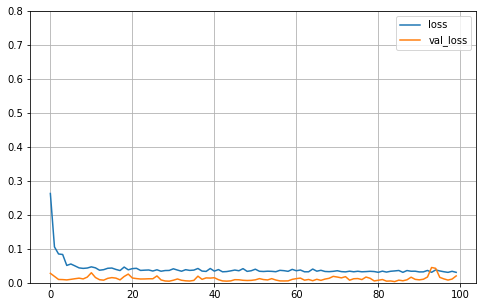

In [711]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

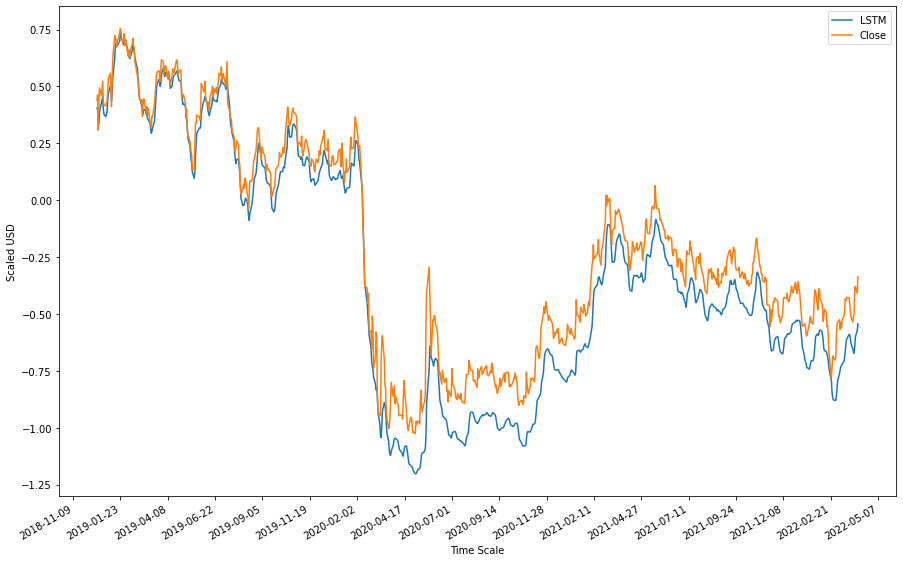

In [712]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr2)
thri=len(X12)-len(Xtstd2)
x_dates=data_dates[k:]
n=n_steps1-1
y=y_ft[thri+n:]
plt.plot(Xtstd2, ypr3, label='LSTM')
plt.plot(Xtstd2, y, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE

In [713]:
rmse3=mean_squared_error(ytst2,ypr3,squared=False)
mape3=mean_absolute_percentage_error(ytst2,ypr3)
print("RSME:",rmse3)
print("MAPE:",mape3)

RSME: 0.14222087234319764
MAPE: 0.47682529242803323


In [714]:
Villa3=(rmse3+mape3)/2

## Val á modeli með minnstu villuna

In [717]:
smallest = 0
if Villa1 < Villa2 and Villa1 < Villa3 :
    smallest = 'Model1'
if Villa2 < Villa1 and Villa2 < Villa3 :
    smallest = 'Model2'
if Villa3 < Villa1 and Villa3 < Villa2 :
    smallest = 'Model3'
print(smallest, "er með minnstu samanlögðu meðalvilluna.")
print("Við veljum þá", smallest)

Model1 er með minnstu samanlögðu meðalvilluna.
Við veljum þá Model1


## Framtíðarspáin

### val á gögnum

In [718]:
spagogn=data.reset_index()['Close']
spagogn.shape

(4169,)

### Mynd af gögnum sem voru valin

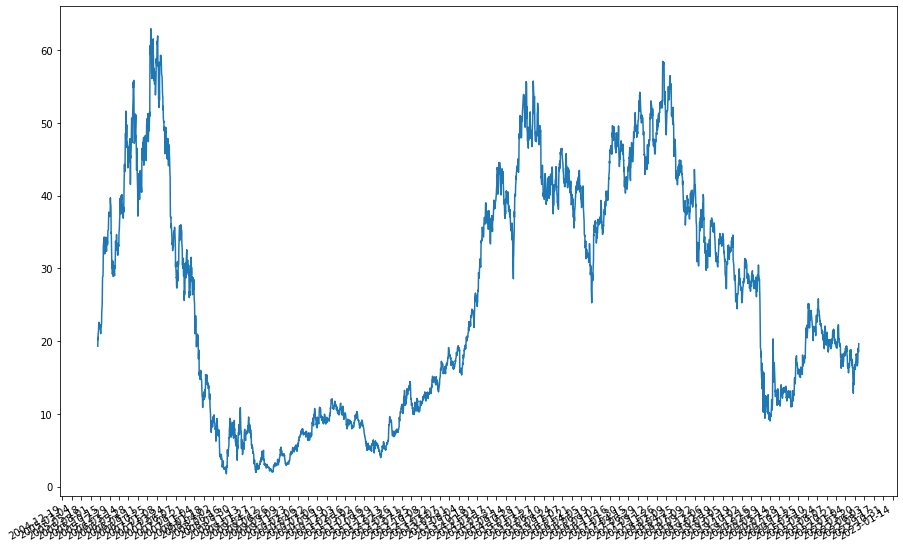

In [719]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
x_dates=data_dates
plt.plot(x_dates, spagogn, label='Close')
plt.gcf().autofmt_xdate()

### Gagnavinnsla

In [720]:
scaler=MinMaxScaler(feature_range=(0,1))
spagogn=scaler.fit_transform(np.array(spagogn).reshape(-1,1))

In [721]:
trainstaerd=int(len(spagogn)*0.65)
tststaerd=len(spagogn)-trainstaerd
trdata,tstdata=spagogn[0:trainstaerd,:],spagogn[trainstaerd:len(spagogn),:1]

In [722]:
trainstaerd,tststaerd

(2709, 1460)

In [723]:
import numpy
def gagnaskipti2(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [724]:
time_step = 100
Xtr3, ytr3 = gagnaskipti2(trdata, time_step)
Xtst3, ytst3 = gagnaskipti2(tstdata, time_step)

In [725]:
Xtr3 =Xtr3.reshape(Xtr3.shape[0],Xtr3.shape[1] , 1)
Xtst3 = Xtst3.reshape(Xtst3.shape[0],Xtst3.shape[1] , 1)

### Modelið

In [726]:

if smallest=='Model1' :
    print("Við notum Model1")
    model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
    model1.compile(loss="mean_squared_error", optimizer="adam")
    model1.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=4,verbose=2)   
if smallest=='Model2' :
    print("Við notum Model2")
    model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
    model2.compile(loss="mean_squared_error", optimizer="adam")
    model2.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 
if smallest=='Model3' :
    print("Við notum Model3")
    model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
    model3.compile(loss="mean_squared_error", optimizer="adam")
    model3.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 

Við notum Model1
Epoch 1/100
652/652 - 34s - loss: 0.0044 - val_loss: 0.0015 - 34s/epoch - 52ms/step
Epoch 2/100
652/652 - 30s - loss: 8.8997e-04 - val_loss: 6.1104e-04 - 30s/epoch - 46ms/step
Epoch 3/100
652/652 - 30s - loss: 5.6591e-04 - val_loss: 9.9663e-04 - 30s/epoch - 47ms/step
Epoch 4/100
652/652 - 31s - loss: 4.7807e-04 - val_loss: 3.5969e-04 - 31s/epoch - 47ms/step
Epoch 5/100
652/652 - 30s - loss: 4.1057e-04 - val_loss: 3.4601e-04 - 30s/epoch - 46ms/step
Epoch 6/100
652/652 - 30s - loss: 3.7393e-04 - val_loss: 3.6834e-04 - 30s/epoch - 46ms/step
Epoch 7/100
652/652 - 30s - loss: 3.3306e-04 - val_loss: 2.3969e-04 - 30s/epoch - 46ms/step
Epoch 8/100
652/652 - 31s - loss: 3.1439e-04 - val_loss: 3.5065e-04 - 31s/epoch - 47ms/step
Epoch 9/100
652/652 - 30s - loss: 3.0533e-04 - val_loss: 2.1234e-04 - 30s/epoch - 46ms/step
Epoch 10/100
652/652 - 30s - loss: 2.8001e-04 - val_loss: 4.1388e-04 - 30s/epoch - 46ms/step
Epoch 11/100
652/652 - 30s - loss: 2.5716e-04 - val_loss: 2.2292e-04 -

### Spágögn búin til

In [727]:
mod=0
if smallest=='Model1' :
  trspa=model1.predict(Xtr3)
  tstspa=model1.predict(Xtst3)
  mod=model1
if smallest=='Model2' :
  trspa=model2.predict(Xtr3)
  tstspa=model2.predict(Xtst3)
  mod=model2
if smallest=='Model3' :
  trspa=model3.predict(Xtr3)
  tstspa=model3.predict(Xtst3)
  mod=model3

In [728]:
trspa=scaler.inverse_transform(trspa)
tstspa=scaler.inverse_transform(tstspa)

### RMSE 

In [729]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(ytr3,trspa))

28.08728815926142

In [730]:
### Spágögn RMSE
math.sqrt(mean_squared_error(ytst3,tstspa))

33.490458308749744

### Train spá og test spá

In [731]:
# shift train predictions for plotting
look_back=100
allt = np.empty_like(spagogn)
allt[:, :] = np.nan
allt[look_back:len(trspa)+look_back, :] = trspa

In [732]:
# shift test predictions for plotting
trainspa = np.empty_like(spagogn)
trainspa[:, :] = np.nan
trainspa[len(trspa)+(look_back*2)+1:len(spagogn)-1, :] = tstspa
testspa=scaler.inverse_transform(spagogn)
x_dates=data_dates

### Mynd af öllu gagnasettinu með test og training gögnum

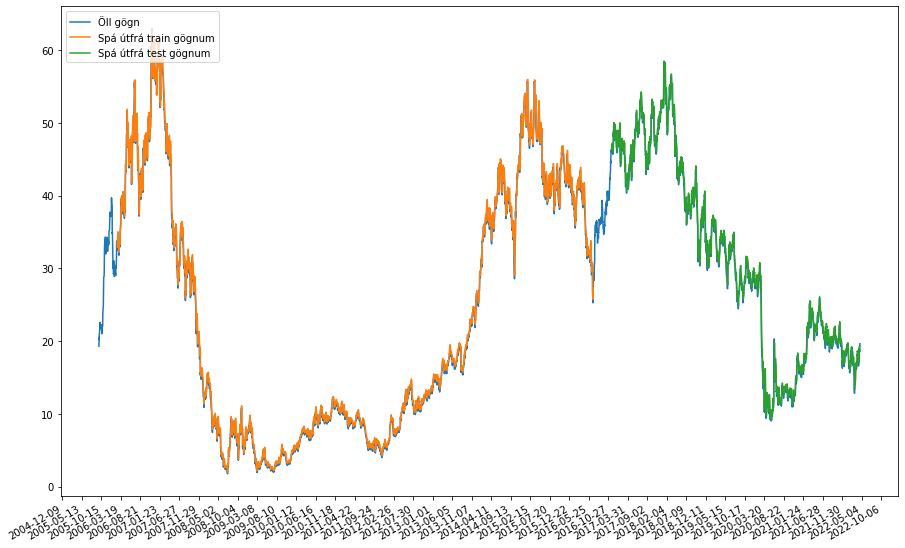

In [733]:
x_dates=data_dates
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=155))
plt.plot(data_dates,testspa,label='Spá útfrá test gögnum')
plt.plot(data_dates,allt, label='Öll gögn')
plt.plot(data_dates,trainspa,label='Spá útfrá train gögnum')
plt.legend(['Öll gögn', 'Spá útfrá train gögnum','Spá útfrá test gögnum'],loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

### Framtíðargögn sett í fylki

In [734]:
len(tstdata)

1460

In [735]:
timi=len(tstdata)-100


In [736]:
x_input=tstdata[timi:].reshape(1,-1)
x_input.shape

(1, 100)

In [737]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
frspa=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = mod.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        frspa.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = mod.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        frspa.extend(yhat.tolist())
        i=i+1
    

#print(frspa)

In [739]:
len(spagogn)

4169

In [740]:
tim=len(spagogn)-100

### Mynd af spá ósamsett

In [741]:
fdata = pd.concat([data, future_dates], axis=0)
framtid=fdata.index.to_frame().reset_index(drop=True)
framtid=framtid.apply(pd.to_datetime)
len(framtid)

4200

In [742]:
spat=len(framtid)-30
sidf=len(framtid)-130

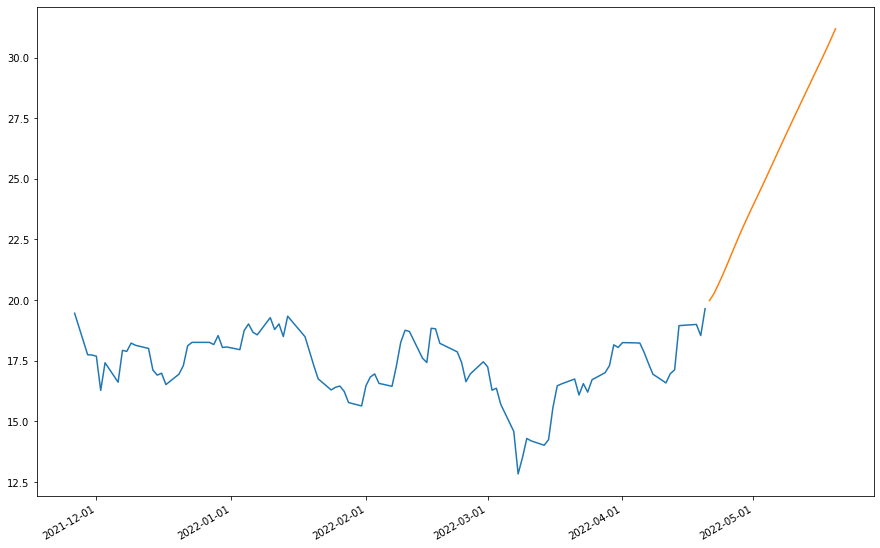

In [743]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[sidf:spat],scaler.inverse_transform(spagogn[tim:]))
plt.plot(framtid[spat:],scaler.inverse_transform(frspa))
plt.gcf().autofmt_xdate()

In [744]:
timm=tim+30

In [745]:
spgfr=spagogn.tolist()
spgfr.extend(frspa)

In [746]:
laga=0
if len(framtid)!=len(spgfr):
  laga=len(framtid)-len(spgfr)


### Mynd af spá samsett

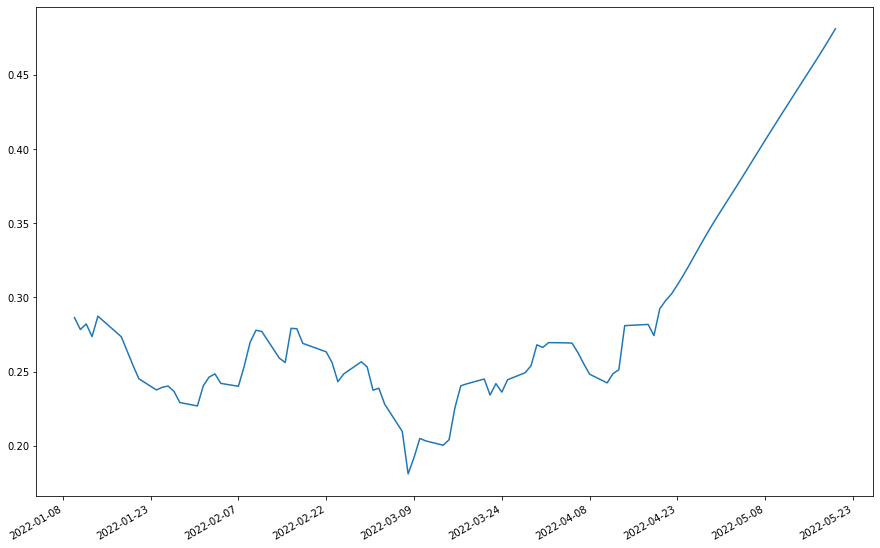

In [747]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.plot(framtid[timm+laga:],spgfr[timm:])
plt.gcf().autofmt_xdate()

In [748]:
spgfr=scaler.inverse_transform(spgfr).tolist()

### Mynd af heildargögnum með spá

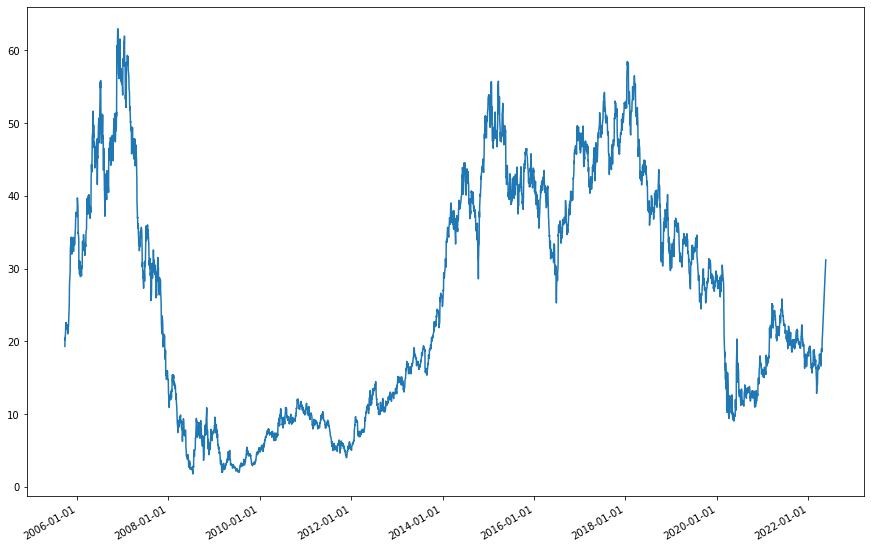

In [749]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[laga:],spgfr)
plt.gcf().autofmt_xdate()